In [1]:
from netCDF4 import Dataset
import cartopy
import xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import os
import nctoolkit as nct
import regex
from matplotlib.ticker import FormatStrFormatter
from cartopy.util import add_cyclic_point
from matplotlib import colors
import geopandas as gpd
import shapely.geometry as shp
import rioxarray
import pyproj
import pandas as pd

nctoolkit is using Climate Data Operators version 1.9.8


In [2]:
nct.deep_clean()

In [3]:
os.chdir('/media/jasmine/Album/Project/')
print(os.getcwd())

/media/jasmine/Album/Project


In [4]:
variable = "siconc"
print(variable)
model = "Multimodel"
print(model)
experiment = "ssp585"
print(experiment)
freq = "SImon"
print(freq)

siconc
Multimodel
ssp585
SImon


## Sea ice selection

#### Selecting mask region

In [7]:
mean = xarray.open_dataset("Data/{}_{}_ice_region.nc".format(variable, model))

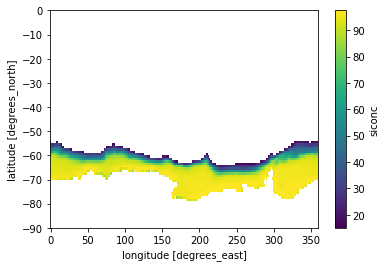

In [8]:
# Select cells with >15% ice cover
ice = mean.where(mean >= 15)
ice[variable].plot()

In [9]:
ice = ice.assign(ice = lambda x: getattr(x, variable) - getattr(x, variable) + 1)

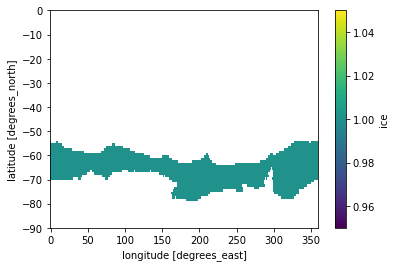

In [10]:
ice['ice'].plot()

In [11]:
ice = ice.drop_vars("siconc")
ice.to_netcdf(path = "Data/Shape/{}_{}_ice_region.nc".format(variable, model), mode = "w", format = "NETCDF4")

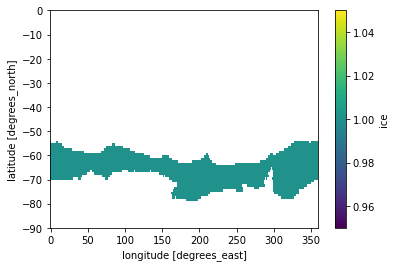

In [12]:
nc = xarray.open_dataset("Data/Shape/{}_{}_ice_region.nc".format(variable, model))
nc['ice'].plot()

#### Making mask

In [5]:
shape = gpd.read_file("Shapes/{}_ice_margin.shp".format(model), crs = "EPSG:4326")
shape

,DN,geometry
0,1,"POLYGON ((-0.500 -54.000, 0.500 -54.000, 0.500..."


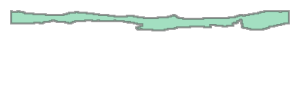

In [6]:
coord1 = shape['geometry'][0].exterior.coords
line1 = shp.LinearRing(coord1)
poly1 = shp.Polygon(line1)
poly1

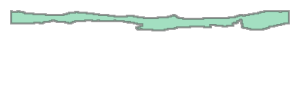

In [7]:
multi_poly = shp.MultiPolygon([poly1])
multi_poly

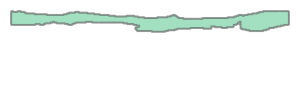

In [8]:
# Expand the region by 1 cells to include open sea
expand = shp.Polygon(multi_poly.buffer(1.0))
expand

In [9]:
ice_new = gpd.GeoSeries(expand)
ice_new

0    POLYGON ((-1.500 -54.000, -1.495 -53.902, -1.4...
dtype: geometry

In [10]:
ice_new.to_file(driver = 'ESRI Shapefile', filename= "Shapes/{}_extended_ice_margin.shp".format(model))